Importing data 

In [1]:
import numpy as np
import pandas as pd
## edit the link to be shorter and accessible from root folder
train = pd.read_csv("data/train.csv",header=None,names=['PairNb','Q1id','Q2id','Q1RT','Q2RT','label'])
test = pd.read_csv("data/test.csv",header=None,names=['PairNb','Q1id','Q2id','Q1RT','Q2RT','label'])

Remarque : Les données fournies ont l'air complètes et il y a pas l'air d'y avoir des fautes d'orthographe.

Implementing a second method : Siamese LSTM

In [2]:
#Getting the raw features that we will be working on :
train_X, train_y = train.iloc[:,:-1], train.iloc[:,-1]
test_X = test.iloc[:,:-1]

In [3]:
#Text cleaning method. Proposée par Elior Cohen (il faudrait voir ce que c'est)
import re
def text2word(text):
    text = str(text).lower()

    # Text cleaning
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = text.split()
    return text

In [4]:
#Loading the embedding file (we use GoogleNews)
embedding_file = "GoogleNews-vectors-negative300.bin.gz"

In [5]:
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
# Prepare vocabulary and look up list
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # placeholder for the [0, 0, ....0] embedding / padding
word2vec = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
stops = set(stopwords.words("english"))

questions_cols = ['Q1RT', 'Q2RT']

# Iterate over the questions only of the training dataset
for dataset in [train_X, test_X]:
    for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for question in questions_cols:
            q2n = []  # q2n -> question to numbers representation
            for word in text2word(row[question]):
                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue
                # add new word into vocabulary and assign look up tables with both word & number
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions with number representations from vocabulary look-up table
            dataset.set_value(index, question, q2n)

embedding_dim = 300
# This will be the embedding matrix, generated from gaussian distribution for words that do not appear at all. (default values)
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embeddings[0] = 0  # So that the padding will be ignored

/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [6]:
#We check that Q1RT and Q2RT are now lists of numbers indicating which words from the vocabulary we built are being used in
#the question
train_X.head()

,PairNb,Q1id,Q2id,Q1RT,Q2RT
0,0,199954,384085,"[1, 2, 3, 4, 3, 5, 6]","[1, 2, 4, 3, 7, 6, 8, 9, 10, 2, 11, 12]"
1,1,128681,237407,"[1, 2, 3, 13, 14, 15, 16, 17, 18]","[1, 2, 4, 19, 13, 20, 21, 22, 18, 23]"
2,2,170846,240621,"[24, 3, 25, 26, 27, 28, 29, 30, 31, 3, 32, 33,...","[36, 21, 3, 37, 26, 29, 38, 3, 32, 33]"
3,3,55110,177468,"[39, 40, 41, 24, 42, 43]","[10, 39, 40, 24, 42, 43]"
4,4,425513,400256,"[1, 44, 45, 14, 16, 46, 47, 16, 48, 49]","[1, 50, 51, 52, 35, 53, 54, 48, 55, 56]"


In [7]:
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        # adds in the embedding dimension's values per row from Google's pre-trained model
        embeddings[index] = word2vec.word_vec(word)

del word2vec # to not clog up memory on the system

In [8]:
# To obtain the max length of the longest question in train/test datasets
max_seq_length = max(train_X.Q1RT.map(lambda x: len(x)).max(),
                     train_X.Q2RT.map(lambda x: len(x)).max(),
                     test_X.Q1RT.map(lambda x: len(x)).max(),
                     test_X.Q2RT.map(lambda x: len(x)).max())

In [9]:
import itertools as itertools
import sklearn as skl
import nltk
from sklearn.model_selection import train_test_split
#Preprocessing data to be fed into the siamese LSTM
from keras.preprocessing.sequence import pad_sequences
LSTM_train_X, LSTM_valid_X, LSTM_train_y, LSTM_valid_y = train_test_split(train_X, train_y, test_size=0.2)

# Split to dictionaries for training, validation and test data
LSTM_train_X = {'left': LSTM_train_X.Q1RT, 'right': LSTM_train_X.Q2RT}
LSTM_valid_X = {'left': LSTM_valid_X.Q1RT, 'right': LSTM_valid_X.Q2RT}
LSTM_test_X = {'left': test_X.Q1RT, 'right': test_X.Q2RT}

# Convert y-values (labels) to their numpy representations
LSTM_train_y = LSTM_train_y.values
LSTM_valid_y = LSTM_valid_y.values

# Zero padding
for dataset, side in itertools.product([LSTM_train_X, LSTM_valid_X], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Checking consistent shapes for data using assert
assert LSTM_train_X['left'].shape == LSTM_train_X['right'].shape # left and right columns are of the same length
assert len(LSTM_train_X['left']) == len(LSTM_train_y) # check if number of rows tally

Using TensorFlow backend.


In [10]:
#Defining the loss and the function used in the last layer of Siamese LSTM
def weighted_log_loss(y_true, y_pred):
    a = 0.165/0.37
    b = (1-0.165)/(1-0.37)
    score = a*y_true*K.log(y_pred+0.00001) + b*(1.0 - y_true)*K.log(1.0 - y_pred+0.00001)
    return -K.mean(score)

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [12]:
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, concatenate, Dense, Dropout, Lambda
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

# Model hyperparameters
hidden_layer_nodes = 50
batch_size = 128
epochs = 50

# declare left and right inputs
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Create an embedding layer to convert words to their embeddings
embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Convert inputs into word embeddings
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# lstm layer that will return an output the size of the number of hidden layer nodes
shared_lstm = LSTM(hidden_layer_nodes)

# run both inputs through shared lstm
output_left = shared_lstm(encoded_left)
output_right = shared_lstm(encoded_right)


def custom_merge(x):
    return exponent_neg_manhattan_distance(x[0],x[1])

merged_vector = Lambda(custom_merge,output_shape=lambda x: (x[0][0], 1))([output_left, output_right])    

# finish off model with output layer
maLSTM = Model([left_input, right_input], [merged_vector])

# optimizer
optimizer = Adam(clipnorm=.9)

# complete model
maLSTM.compile(optimizer=optimizer, loss=weighted_log_loss, metrics=[weighted_log_loss,'accuracy'])

# summarize the model
print(maLSTM.summary())

# Start training
model_trained = maLSTM.fit([LSTM_train_X['left'], LSTM_train_X['right']], LSTM_train_y, batch_size=batch_size, epochs=epochs,
                            validation_data=([LSTM_valid_X['left'], LSTM_valid_X['right']], LSTM_valid_y), verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 67)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 67)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 67, 300)      5807400     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 50)           70200       embedding_2[0][0]                
          

Epoch 33/50
64080/64080 [==============================] - 49s 761us/step - loss: 0.2010 - weighted_log_loss: 0.2010 - acc: 0.8770 - val_loss: 0.2816 - val_weighted_log_loss: 0.2816 - val_acc: 0.8237
Epoch 34/50
64080/64080 [==============================] - 49s 758us/step - loss: 0.1982 - weighted_log_loss: 0.1982 - acc: 0.8803 - val_loss: 0.2825 - val_weighted_log_loss: 0.2825 - val_acc: 0.8340
Epoch 35/50
64080/64080 [==============================] - 49s 759us/step - loss: 0.1958 - weighted_log_loss: 0.1958 - acc: 0.8821 - val_loss: 0.2849 - val_weighted_log_loss: 0.2849 - val_acc: 0.8142
Epoch 36/50
64080/64080 [==============================] - 49s 757us/step - loss: 0.1930 - weighted_log_loss: 0.1930 - acc: 0.8846 - val_loss: 0.2813 - val_weighted_log_loss: 0.2813 - val_acc: 0.8348
Epoch 37/50
64080/64080 [==============================] - 49s 761us/step - loss: 0.1913 - weighted_log_loss: 0.1913 - acc: 0.8858 - val_loss: 0.2826 - val_weighted_log_loss: 0.2826 - val_acc: 0.8390


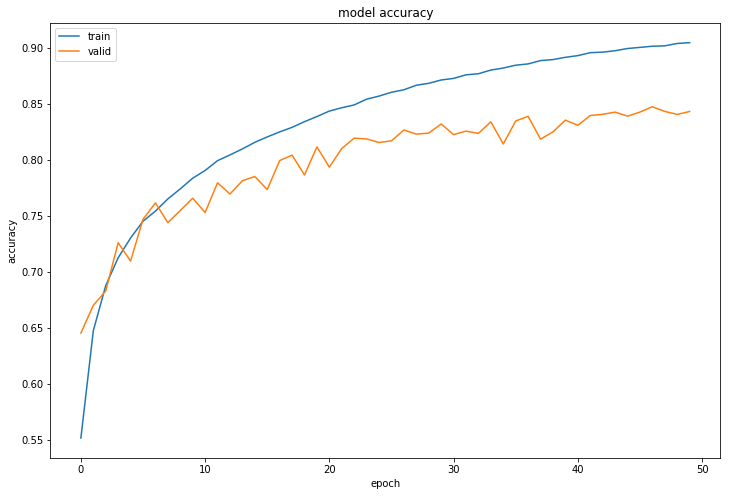

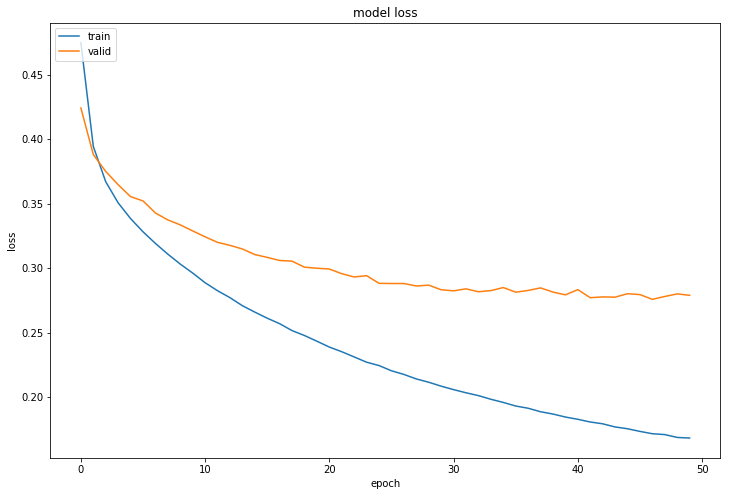

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(model_trained.history['acc'])
plt.plot(model_trained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [16]:
LSTM_test_X['left'] = pad_sequences(LSTM_test_X['left'], maxlen=max_seq_length)
LSTM_test_X['right'] = pad_sequences(LSTM_test_X['right'], maxlen=max_seq_length)
prob_y = maLSTM.predict([LSTM_test_X['left'], LSTM_test_X['right']])

## dump into .csv for Kaggle submission
submission = pd.DataFrame()
submission['Id'] = test_X['PairNb']
submission['Score'] = prob_y
submission.to_csv("submission_siameseLSTM_2.csv", index=False)